In [ ]:
!pip install yahoo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf


In [2]:
# Download SBI stock price data (Last 5 years)
sbi_data = yf.download("SBIN.NS", start="2018-01-01", end="2024-01-01")

# Check dataset
print(sbi_data.head())

# Use only the "Close" price for prediction
data = sbi_data[['Close']]


[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker         SBIN.NS     SBIN.NS     SBIN.NS     SBIN.NS   SBIN.NS
Date                                                                
2018-01-01  289.056152  294.374177  288.303140  292.350508  12182400
2018-01-02  285.432373  290.844529  283.644014  290.844529  14797364
2018-01-03  285.055878  288.444363  284.396995  287.361909  13857373
2018-01-04  290.373901  291.974028  285.338238  286.608924  24517099
2018-01-05  288.350220  293.103492  287.644286  293.103492  14580575


In [3]:
# Normalize the data (scale between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Define function to create sequences
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])  # Previous `time_steps` prices
        y.append(data[i+time_steps])  # Next day's price
    return np.array(X), np.array(y)

# Create sequences for training
time_steps = 60  # Lookback period (e.g., last 60 days)
X, y = create_sequences(data_scaled, time_steps)

# Split into training (80%) and testing (20%)
split_index = int(0.8 * len(X))
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]

# Reshape input for RNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [4]:
# Define RNN model
model = Sequential([
    SimpleRNN(units=50, activation="relu", return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    SimpleRNN(units=50, activation="relu"),
    Dropout(0.2),
    Dense(units=1)  # Output layer for price prediction
])

# Compile model
model.compile(optimizer="adam", loss="mean_squared_error")

# Model Summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 60, 50)              │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,701 (30.08 KB)

 Trainable params: 7,701 (30.08 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0342 - val_loss: 0.0054
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0074 - val_loss: 0.0016
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0058 - val_loss: 5.8134e-04
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0046 - val_loss: 0.0026
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0032 - val_loss: 4.0038e-04
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0043 - val_loss: 0.0018
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0034 - val_loss: 0.0012
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0029 - val_loss: 5.9893e-04
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0034 - val_loss: 0.0011
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0028 - val_loss: 3.3838e-04
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


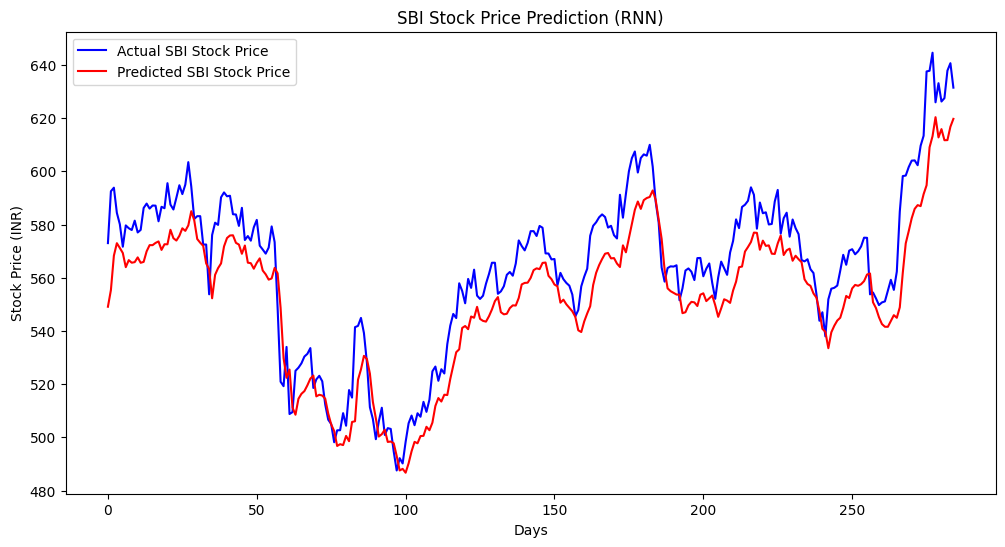

In [6]:
# Predict stock prices
y_pred = model.predict(X_test)

# Convert predictions back to original scale
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test)

# Plot predictions vs actual prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual SBI Stock Price", color="blue")
plt.plot(y_pred_actual, label="Predicted SBI Stock Price", color="red")
plt.xlabel("Days")
plt.ylabel("Stock Price (INR)")
plt.legend()
plt.title("SBI Stock Price Prediction (RNN)")
plt.show()


In [8]:
# Save trained model
model.save("sbi_rnn_model.h5")

In [12]:
import numpy as np
import pandas as pd
import yfinance as yf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Load SBI stock data from Yahoo Finance
sbi_data = yf.download("SBIN.NS", start="2023-01-01", end="2024-01-01")  # Adjust date range as needed

# Use only the "Close" price
data = sbi_data[['Close']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Load trained model
model = load_model("sbi_rnn_model.h5")

# Get the last 60 days of stock prices from the dataset
last_60_days = data_scaled[-60:]  # Ensure we have 60 days

# Take user input for the last day's closing price
last_day_price = float(input("Enter the last closing price of SBI stock: ₹"))

# Replace the last value in the sequence with the user input (optional)
last_60_days[-1] = scaler.transform(np.array([[last_day_price]]))  # Ensure consistency

# Reshape to match model input shape (1, 60, 1)
last_60_days = last_60_days.reshape(1, 60, 1)

# Predict the next day's stock price
predicted_scaled = model.predict(last_60_days)
predicted_price = scaler.inverse_transform(predicted_scaled)[0][0]

# Display prediction
print(f"Predicted SBI Stock Price for the next day: ₹{predicted_price:.2f}")


[*********************100%***********************]  1 of 1 completed


Enter the last closing price of SBI stock: ₹737.20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
Predicted SBI Stock Price for the next day: ₹690.73
